<h1 style='text-align: center;'> 
Physics-Informed Neural Networks (PINNs)
</h1>

`Narváez J.`
<p style='text-align: justify;'>

<p style='text-align: justify;'>  
In this notebook, we will introduce the concept of Physics-Informed Neural Networks (PINNs). We will create simple examples of how it works for solving ODES. </p>

# Solving ODES with PINNs

<p style='text-align: justify;'>  
The process of solving a differential equation with a neural network using the ODE itself to define the cost function is known as <b> physics-informed neural network</b>.
</p>

Let's consider the next general ODE:

<div id="ODE"></div>

$$
\begin{equation} \label{ODE} \tag{1}
 f(x, u(x), u^\prime(x), u^{\prime\prime}(x), \cdots, u^{(n)}(x))=0 \hspace{0.5cm}\text{for } x\in D,
\end{equation}
$$

<p style='text-align: justify;'> 
subject to some Boundary Conditions in $\partial D$. Here, $u(x)$ is the function to be evaluated in its domain $D$. Now, we chose a trial solution $\Psi(x)$ such that, by construction, it satisfied the boundary condition, as follows,
</p>

<div id="Trial"></div>

$$
\begin{equation} \label{Trial} \tag{2}
 \Psi(x, w) = A(x) + F(x, NN(x, w)),
\end{equation}
$$

<p style='text-align: justify;'> 
where $NN(x, w)$ is a single-output neural network whose weights and biases are denoted by $w$, $F$ is some function involving the neural network, and $A(x)$ does not contain tunable parameters that satisfy the boundary condition. In this way, $F$ is constructed such that it doesn't contribute to the BC's.
</p>

<p style='text-align: justify;'> 
If $\Psi(x)$ was the exact solution, then it has to satisfy the condition:
</p>

<div id="PsiReq"></div>

$$
\begin{equation} \label{PsiReq} \tag{3}
 f(x, \Psi(x), \Psi^\prime(x), \Psi^{\prime\prime}(x), \cdots, \Psi^{(n)}(x))=0 \hspace{0.5cm}\text{for all} x\in D,
\end{equation}
$$

Thus, let turn this condition to our cost function. This is,

<div id="CostF"></div>

$$
\begin{equation} \label{CostF} \tag{4}
 C(w) = \frac{1}{2} \sum_{x \in D} \left(f(x, \Psi(x), \Psi^\prime(x), \Psi^{\prime\prime}(x), \cdots, \Psi^{(n)}(x))\right)^2.
\end{equation}
$$

## Dirichlet's Boundary Conditions

## Example 1

Let's solve the next ordinary differential equation:

<div id="ODEsystem"></div>

$$
\begin{equation} \label{ODESystem} \tag{5}
  u^\prime (t)= f(u,t), 
\end{equation}
$$

with $t \in T$ and a known initial condition, $u(0) = u_0$. As we saw above, we approximate the solution for the trial solution ([2](#Trial)), which in this case takes the form:

<div id="TrialExample"></div>

$$
\begin{equation} \label{TrialExample} \tag{6}
  \Psi(t, w)= u_0 + t \cdot NN(t, w), 
\end{equation}
$$

then, it follows the BC's immediately. Replacing ([6](#TrialExample)) and ([5](#ODEsystem)) in ([4](#CostF)) we get

<div id="CostExample"></div>

$$
\begin{equation} \label{CostExample} \tag{7}
  C(w)= \frac{1}{2}\sum_i \left(\Psi^\prime(t_i)-f(\Psi(t_i), t_i)\right)^2.
\end{equation}
$$

The choice of $t_i$ could be done in many ways: it can be random, it can be a grid, etc.

<p style='text-align: justify;'> 
From the above equation, we see that when we take the gradient of C with respect to parameters: weights and biases, $\nabla_w$, then we don't calculate only partial derivatives with respect to $w$, but total derivatives with respect to inputs $t$. It can be complicated and expensive. For this task, we will use libraries that calculate this efficiently.
</p>

Now, let's consider the case $f(u, t) = \cos{(2\pi t)}$ with $T=[0, 1]$ and the initial condition $u_0 = 1$.

We will use the library $\texttt{Flux}$ to implement the code. You can find more information about this tool [here](https://fluxml.ai/Flux.jl/stable/).

In [1]:
using Distributions # Create uniform randomly distribution
using Flux          # Machine learning
using LaTeXStrings  # Type LaTeX syntax
using LinearAlgebra # Linear Algebra's operations
using Plots         # Display plots
using Statistics    # Basic statistics functionality.

In [2]:
# We define a NN with: 1 input layer, 2 hidden layers and 1 output layer
NNODE = Chain(x -> [x], # Take in a scalar and transform it into an array
            Dense(1, 32, tanh), # It uses the hyperbolic tangent as activation function
            Dense(32,1), first) # Take first value, i.e. return a scalar
NNODE(1.0)

0.03881440326233153

In [3]:
u0 = 1. # Initial condition
T = 0:1f-2:1f0 # Domain of solution V
ϵ = sqrt(eps(Float32)); # Parameter Δx for differentiation

In [4]:
Ψ(t; NN, u0) = t*NN(t) + u0 # Trial solution

Ψ (generic function with 1 method)

In [5]:
Ψ1(t) = Ψ(t; NN=NNODE, u0 = u0)

Ψ1 (generic function with 1 method)

To calculate the derivative of $\Psi$ respect to inputs, we approximate this by the central discrete derivative, i.e., 

<div id="CentralDer"></div>

$$
\begin{equation} \label{CentralDer} \tag{8}
  u^\prime (t)= \frac{u(t+\Delta t)-u(t-\Delta t)}{2\Delta t}, 
\end{equation}
$$

in our case, we take $\Delta t = \sqrt{\epsilon}$ where $\epsilon$ is the machine precision of the floating point of type $\texttt{Float32}$.

In [6]:
loss1() = 0.5*mean(abs2(((Ψ1(t+ϵ)-Ψ1(t-ϵ))/(2*ϵ)) - cos(2π*t)) for t in T) # Loss function

loss1 (generic function with 1 method)

In [7]:
lr = 1e-3 # learning rate
it = 5000 # Number of iterations

5000

In [8]:
opt = Flux.Adam(lr) # ADAM method (Stochastic optimization)
data = Iterators.repeated((), it) # Iterations
iter = 0
history1 = zeros(it)
cb = function () #callback function to observe the training
    global iter += 1
    global history1
    history1[iter]= loss1()
    if iter % 500 == 0
        display(iter)
        display(history1[iter])
    end
end
display(loss1())

0.25388341391978236

In [9]:
Flux.train!(loss1, Flux.params(NNODE), data, opt; cb=cb)

500

0.02666973373080339

1000

0.012756875268994636

1500

0.008560490516448112

2000

0.00020743749943966572

2500

5.219993544326645e-5

3000

2.9135804871405898e-5

3500

2.211857906358057e-5

4000

1.8443987596499107e-5

4500

1.4810053708647212e-5

5000

1.5885189670728526e-5

The analytical solution to the last problem is given by:

<div id="AnSol1"></div>

$$
\begin{equation} \label{AnSOl1} \tag{9}
  u^\prime (t)= u_0 + \frac{1}{2\pi} \sin{(2\pi t)}.
\end{equation}
$$

In [10]:
F_target1(t) = 1.0 + sin(2π*t)/2π # Analytical solution

F_target1 (generic function with 1 method)

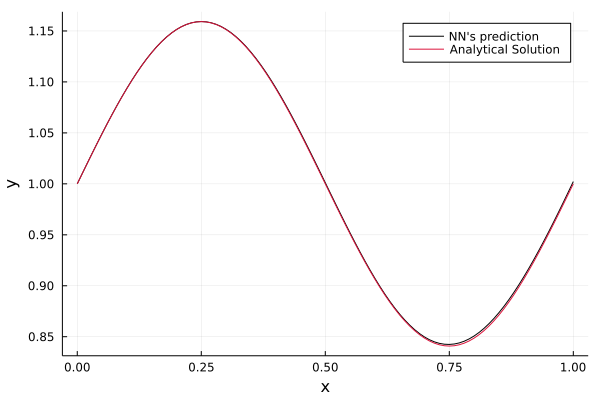

In [11]:
plot(T,Ψ1.(T),color = "black", label="NN's prediction")
plot!(T, F_target1.(T), color = "crimson", label = "Analytical Solution")
xlabel!("x")
ylabel!("y")

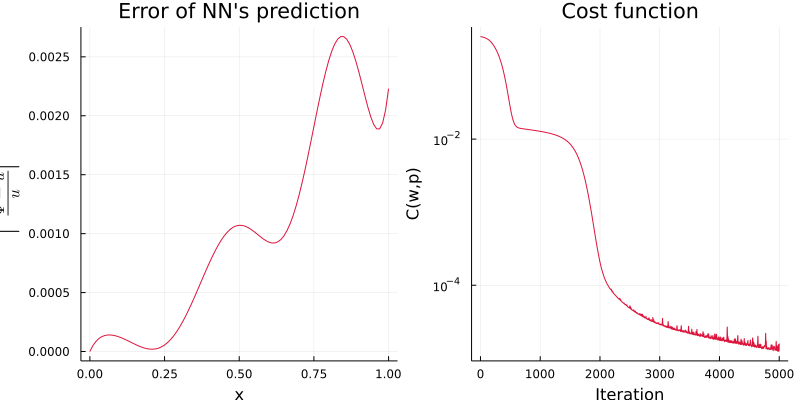

In [12]:
p1 = plot(T,abs.((Ψ1.(T) - F_target1.(T))./F_target1.(T)),color = "crimson", title="Error of NN's prediction",
        label=false, xlabel="x", ylabel=L"\left|\frac{\Psi - u}{u}\right|")
p2 = plot(1:it, history1, color="crimson", title="Cost function", label=false, 
        xlabel="Iteration", yaxis=:log, ylabel = "C(w,p)")
plot(p1, p2, layout = (1, 2), legend = false, size = (800, 400))

## Example 2

Let's consider an exponential decay of a physical quantity $u(x)$ represented by the next ODE:

<div id="solve_expdec"></div>
$$
\begin{equation} \label{solve_expdec} \tag{10}
  u'(t) = -\gamma u(t),
\end{equation}
$$

and the initial condition $u(0)=1$ and $t\in[0,1]$. In this example, we'll take $\gamma = 2$.

The analytical solution of the IVP in ([10](#solve_expdec)) is

<div id="AnSOl2"></div>
$$
\begin{equation}\label{AnSOL2} \tag{11}
  u(x) = u_0 \exp\left(-\gamma u\right).
\end{equation}
$$

In [13]:
NNODE2 = Chain(x -> [x], # Take in a scalar and transform it into an array
           Dense(1,32,tanh),
           Dense(32,1),first) # Take first value, i.e. return a scalar
NNODE2(1.0)

0.2722631040181043

In [14]:
Ψ2(t) = Ψ(t; NN=NNODE2, u0 = 10)

Ψ2 (generic function with 1 method)

In [15]:
gamma = 2
loss2() = 0.5*mean(abs2(((Ψ2(t+ϵ)-Ψ2(t-ϵ))/(2*ϵ)) + gamma*Ψ2(t)) for t in T) # Loss function

loss2 (generic function with 1 method)

In [16]:
iter = 0
history2 = zeros(it)
cb2 = function () #callback function to observe training
    global iter += 1
    global history2
    history2[iter]= loss2()
    if iter % 500 == 0
        display(iter)
        display(history2[iter])
    end
end
display(loss2())

209.29464721679688

In [17]:
Flux.train!(loss2, Flux.params(NNODE2), data, opt; cb = cb2)

500

29.157119750976562

1000

17.926589965820312

1500

4.278508186340332

2000

1.2832443714141846

2500

0.8071981072425842

3000

0.4549887776374817

3500

0.22864869236946106

4000

0.10623987764120102

4500

0.05390641838312149

5000

0.032758928835392

In [18]:
F_target2(t) = 10*exp(-gamma*t) # Analytical solution

F_target2 (generic function with 1 method)

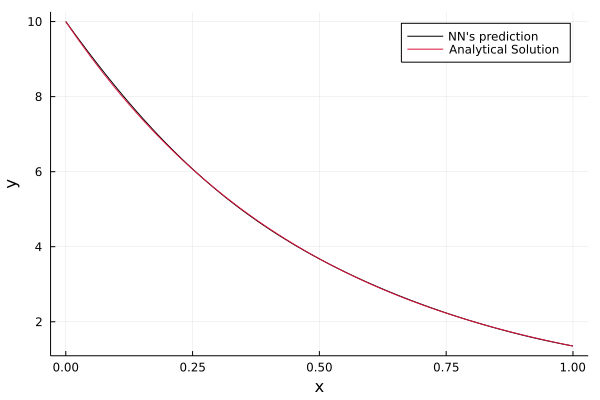

In [19]:
plot(T,Ψ2.(T),color = "black", label="NN's prediction")
plot!(T, F_target2.(T), color = "crimson", label = "Analytical Solution")
xlabel!("x")
ylabel!("y")

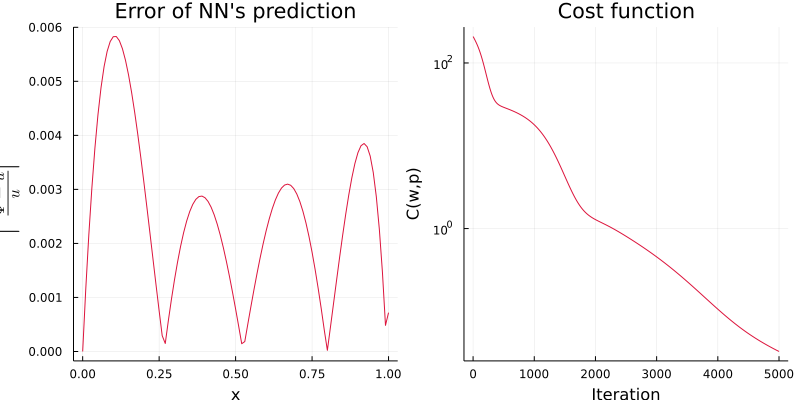

In [20]:
p1 = plot(T,abs.((Ψ2.(T) - F_target2.(T))./F_target2.(T)),color = "crimson", title="Error of NN's prediction",
        label=false, xlabel="x", ylabel=L"\left|\frac{\Psi - u}{u}\right|")
p2 = plot(1:it, history2, color="crimson", title="Cost function", label=false, 
        xlabel="Iteration", yaxis=:log, ylabel = "C(w,p)")
plot(p1, p2, layout = (1, 2), legend = false, size = (800, 400))

## Example 3

- ODE: 

<div id="ExamODE3"></div>
$$
\begin{equation} \label{ExamODE3} \tag{12}
  u'(t) + \left(t + \frac{1+3t^2}{1+t+t^3}\right)u= t^3+ 2t + t^2\left(\frac{1+3t^2}{1+t+t^3}\right),
\end{equation}
$$

with $u(0)=1$ and $t \in [0,1]$.

- Analytical solution:

<div id="AnSOL3"></div>
$$
\begin{equation} \label{ANSOL3} \tag{13}
  u(t) = \frac{1}{1+t+t^3}e^{-\frac{t^2}{2}} + t^2.
\end{equation}
$$

In [21]:
NNODE3 = Chain(x -> [x], # Take in a scalar and transform it into an array
           Dense(1,32,tanh),
           Dense(32,1),first) # Take first value, i.e. return a scalar
NNODE2(1.0)

-8.645674679256759

In [22]:
Ψ3(t) = Ψ(t; NN=NNODE3, u0 = 1)

Ψ3 (generic function with 1 method)

In [23]:
loss3() = 0.5*mean(abs2(((Ψ3(t+ϵ)-Ψ3(t-ϵ))/(2*ϵ)) + (t + (1+3*t^2)/(1+t+t^3))*Ψ3(t) - (t^3 + 2*t + t^2*((1+3*t^2)/(1+t+t^3)))) for t in T) # Loss function

loss3 (generic function with 1 method)

In [24]:
iter = 0
history3 = zeros(it)
cb3 = function () #callback function to observe training
    global iter += 1
    global history3
    history3[iter]= loss3()
    if iter % 500 == 0
        display(iter)
        display(history3[iter])
    end
end
display(loss3())

0.3877154290676117

In [25]:
Flux.train!(loss3, Flux.params(NNODE3), data, opt; cb = cb3)

500

0.0012853194493800402

1000

0.0011872696923092008

1500

0.0010789487278088927

2000

0.0009669774444773793

2500

0.0008409860311076045

3000

0.0006816517561674118

3500

0.00045405884156934917

4000

0.0001969302975339815

4500

0.000108192594780121

5000

9.603409853298217e-5

In [26]:
F_target3(t) = exp(-t^2 / 2)/(1+t+t^3)+t^2 # Analytical solution

F_target3 (generic function with 1 method)

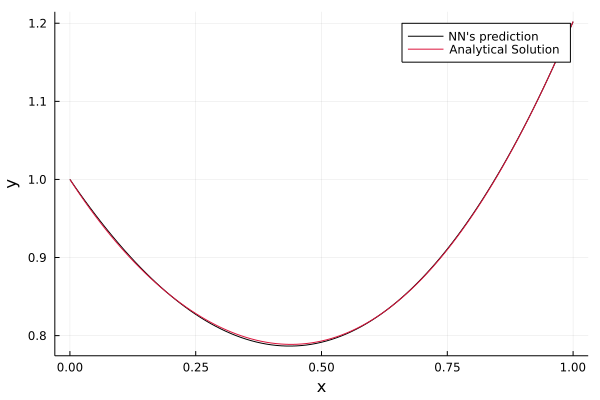

In [27]:
plot(T,Ψ3.(T),color = "black", label="NN's prediction")
plot!(T, F_target3.(T), color = "crimson", label = "Analytical Solution")
xlabel!("x")
ylabel!("y")

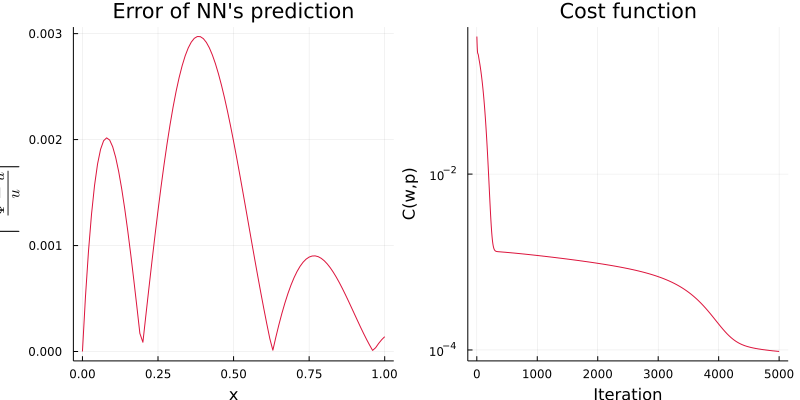

In [28]:
p1 = plot(T,abs.((Ψ3.(T) - F_target3.(T))./F_target3.(T)),color = "crimson", title="Error of NN's prediction",
        label=false, xlabel="x", ylabel=L"\left|\frac{\Psi - u}{u}\right|")
p2 = plot(1:it, history3, color="crimson", title="Cost function", label=false, 
        xlabel="Iteration", yaxis=:log, ylabel = "C(w,p)")
plot(p1, p2, layout = (1, 2), legend = false, size = (800, 400))

## Mixed boundary condition

## Example 1

## Referencias

1. `Lagaris, Isaac & Likas, Aristidis & Fotiadis, Dimitrios. (1998). Artificial neural networks for solving ordinary and partial differential equations. IEEE Transactions on Neural Networks. 9. 987-1000. 10.1109/72.712178.`

2. `Rackauckas, Chris. (2020). Introduction to Scientific Machine Learning through Physics-Informed Neural Networks.`https://book.sciml.ai/course/

3. `Larrañaga, Eduard. (2022). Notes of Physics Informed Neural Networks (PINNs).`